# AquaGrade CNN Model

## Setups

### Necessary Paths

In [6]:
# * Load the absolute folder of the current directory in Colab
COLAB_DIR = os.path.abspath(os.getcwd())

# * Define paths correctly without the leading '/' in the relative path
PROJECT_PATH = os.path.join(COLAB_DIR, 'drive', 'MyDrive', 'colab_nb', 'aquagrade_pkg')

# * Load config path
CONFIG_PATH = os.path.join(PROJECT_PATH, 'config')

# * Load data path
DATA_PATH = os.path.join(PROJECT_PATH, 'data')

# * Joins aquagrade_pkg/src
SRC_PATH = os.path.join(PROJECT_PATH, 'src')

# * Load the requirements.txt path
REQUIREMENTS_PATH = os.path.join(PROJECT_PATH, 'requirements.txt')

# * Load the dataset path
DATASET_PATH = os.path.join(PROJECT_PATH, 'data', 'annotated', 'dataset')

# * Subset of dataset, or child folders of dataset folder
TRAIN_IMAGES_PATH = os.path.join(DATASET_PATH, 'train', 'images')
VALID_IMAGES_PATH = os.path.join(DATASET_PATH, 'valid', 'images')
TEST_IMAGES_PATH = os.path.join(DATASET_PATH, 'test', 'images')

# * Data cleaned directories
CLEANED_TRAIN_IMAGES_PATH = os.path.join(DATA_PATH, 'clean', 'train')
CLEANED_VALID_IMAGES_PATH = os.path.join(DATA_PATH, 'clean', 'valid')
CLEANED_TEST_IMAGES_PATH = os.path.join(DATA_PATH, 'clean', 'test')

### Installation of Dependencies/Libraries

In [8]:
# Install the requirements
!pip install -r {REQUIREMENTS_PATH}

ERROR: Could not open requirements file: [Errno 2] No such file or directory: '/content/drive/MyDrive/colab_nb/aquagrade_pkg/requirements.txt'


### Imports

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

# * Import general libraries

# * For pathfinding or navigating the file system
import os
import yaml
import math
from pathlib import Path
import random
import hashlib
import shutil

# * Import necessary libraries for image processing
import numpy as np
from PIL import Image
from PIL import ImageOps

# * Imports for plotting
import matplotlib.pyplot as plt
import pandas as pd

# * Imports for GUI libraries
from tqdm import tqdm

# * Imports for documentations
from docx import Document
from docx.shared import Inches

import wandb

# * Import necessary libraries for model training
import torch
import torchmetrics
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch import nn, optim
import torchvision.models as models
import torchvision.transforms.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

# * Import sci-kit cross-validation libraries
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, precision_recall_curve, ConfusionMatrixDisplay

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


ModuleNotFoundError: No module named 'docx'

## Preprocessing Data Pipeline

### Reading Data from a YAML-Formatted

In [ ]:
def read_yaml_file(file_name):
    with open(os.path.join(CONFIG_PATH, file_name), 'r') as file:
        yaml_data = yaml.safe_load(file)

    print(f"\nContent of {file_name}:")
    print(yaml.dump(yaml_data, default_flow_style=False))

    return yaml_data

### Content of YAML Configuration Data

In [ ]:
# Read dataset_paths.yaml
dataset_yaml = read_yaml_file('dataset_paths.yaml')

# Verify paths within the subset of dataset
print("\nVerifying paths:")
print(f"Train path exists: {os.path.exists(os.path.join(DATASET_PATH, dataset_yaml['train']))}")
print(f"Validation path exists: {os.path.exists(os.path.join(DATASET_PATH, dataset_yaml['val']))}")
print(f"Test path exists: {os.path.exists(os.path.join(DATASET_PATH, dataset_yaml['test']))}")

# Print full paths for reference
print("\nFull paths:")
print(f"Train: {os.path.abspath(os.path.join(DATASET_PATH, dataset_yaml['train']))}")
print(f"Validation: {os.path.abspath(os.path.join(DATASET_PATH, dataset_yaml['val']))}")
print(f"Test: {os.path.abspath(os.path.join(DATASET_PATH, dataset_yaml['test']))}")

# Read class_names.yaml
read_yaml_file('class_names.yaml')

# Read training parameters through YAML
read_yaml_file('training_params.yaml')


Content of dataset_paths.yaml:
test: /content/drive/MyDrive/colab_nb/aquagrade_pkg/data/annotated/dataset/test/images
train: /content/drive/MyDrive/colab_nb/aquagrade_pkg/data/annotated/dataset/train/images
val: /content/drive/MyDrive/colab_nb/aquagrade_pkg/data/annotated/dataset/valid/images


Verifying paths:
Train path exists: True
Validation path exists: True
Test path exists: True

Full paths:
Train: /content/drive/MyDrive/colab_nb/aquagrade_pkg/data/annotated/dataset/train/images
Validation: /content/drive/MyDrive/colab_nb/aquagrade_pkg/data/annotated/dataset/valid/images
Test: /content/drive/MyDrive/colab_nb/aquagrade_pkg/data/annotated/dataset/test/images

Content of class_names.yaml:
class_names:
- Bangus-SKIN -0-
- Bangus-SKIN -1-
- Bangus-SKIN -2-
- Bangus-GILL-COVER -0-
- Bangus-GILL-COVER -1-
- Bangus-GILL-COVER -2-
- Bangus-GILL-COVER -3-
- Bangus-EYE-CLARITY -0-
- Bangus-EYE-CLARITY -1-
- Bangus-EYE-SHAPE -0-
- Bangus-EYE-SHAPE -1-
- Bangus-EYE-SHAPE -2-
- Tilapia-SKIN 

{'training': {'num_epochs': 1000,
  'batch_size': 32,
  'learning_rate': 0.001,
  'num_folds': 5,
  'output_dir': '/content/drive/MyDrive/colab_nb/models/saved'},
 'augmentations': {'resize_scale': [0.8, 1.0],
  'horizontal_flip': 0.5,
  'vertical_flip': 0.2,
  'rotation_degrees': 15,
  'brightness': 0.2,
  'contrast': 0.2,
  'saturation': 0.2,
  'hue': 0.1,
  'gaussian_blur_kernel': [5, 9],
  'gamma_range': [0.8, 1.2],
  'erasing_scale': [0.02, 0.1],
  'erase_ratio': [0.3, 3.3]},
 'logging': {'version_prefix': 'AquaGrade-v',
  'save_metrics': True,
  'log_dir': 'content/drive/MyDrive/colab_nb/aquagrade_pkg/models/'}}

### Setup for Splitting the Dataset

In [ ]:
# Function to load and resize images
def load_and_resize_image(image_path, target_size=(100, 100)):
    try:
        with Image.open(image_path) as img:
            return img.resize(target_size, Image.LANCZOS)
    except Exception as e:
        print(f"Error loading image {image_path}: {str(e)}")
        return Image.new('RGB', target_size, color='red')

# Function to create image grid
def create_image_grid(images_path, grid_size):
    image_files = [f for f in os.listdir(images_path) if f.lower().endswith(
        ('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    grid = np.zeros((grid_size * 100, grid_size * 100, 3), dtype=np.uint8)
    for i, img_file in enumerate(tqdm(image_files[:grid_size*grid_size], desc="Loading images")):
        if i >= grid_size * grid_size:
            break
        row = i // grid_size
        col = i % grid_size
        img_path = os.path.join(images_path, img_file)
        img = load_and_resize_image(img_path)
        grid[row*100:(row+1)*100, col*100:(col+1)*100] = np.array(img)
    return grid, len(image_files)

### Function for Loading YAML Configurations

In [ ]:
# Function to load YAML configurations
def load_yaml_config(YAML_PATH):
    with open(YAML_PATH, 'r') as file:
        data = yaml.safe_load(file)
    return data

### Dataset Visualization

In [ ]:
# Calculate grid size for all sets
train_grid_size = min(100, math.ceil(
    math.sqrt(len(os.listdir(TRAIN_IMAGES_PATH)))))
valid_grid_size = min(100, math.ceil(
    math.sqrt(len(os.listdir(os.path.join(DATASET_PATH, 'valid', 'images'))))))
test_grid_size = min(100, math.ceil(
    math.sqrt(len(os.listdir(os.path.join(DATASET_PATH, 'test', 'images'))))))

# Create grids
train_grid, train_total = create_image_grid(TRAIN_IMAGES_PATH, train_grid_size)
val_grid, val_total = create_image_grid(VALID_IMAGES_PATH, valid_grid_size)
test_grid, test_total = create_image_grid(TEST_IMAGES_PATH, test_grid_size)

# Display the grids
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(60, 20))

ax1.imshow(train_grid)
ax1.axis('off')
ax1.set_title(f"Training Dataset Images ({train_grid_size}x{train_grid_size} grid)")

ax2.imshow(val_grid)
ax2.axis('off')
ax2.set_title(f"Validation Dataset Images ({valid_grid_size}x{valid_grid_size} grid)")

ax3.imshow(test_grid)
ax3.axis('off')
ax3.set_title(f"Test Dataset Images ({test_grid_size}x{test_grid_size} grid)")

# * Plot the grids graphically
plt.tight_layout()
plt.show()

print(f"Total training images displayed: {min(train_grid_size*train_grid_size, train_total)}")
print(f"Total training images in dataset: {train_total}")
print(f"Total validation images displayed: {min(valid_grid_size*valid_grid_size, val_total)}")
print(f"Total validation images in dataset: {val_total}")
print(f"Total test images displayed: {min(test_grid_size*test_grid_size, test_total)}")
print(f"Total test images in dataset: {test_total}")

Output hidden; open in https://colab.research.google.com to view.

### Loading of Data from YAML-Specified Paths

In [ ]:
def load_images_from_path(path, target_size=(224, 224)):
    images = []
    labels = []
    class_names = sorted(os.listdir(path))
    for class_index, class_name in enumerate(class_names):
        class_path = os.path.join(path, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = load_img(img_path, target_size=target_size)
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(class_index)
    return np.array(images), np.array(labels), class_names

# * ~/aquagrade_pkg/.../config/dataset_paths.yaml
dataset_subset_path = load_yaml_config(os.path.join(CONFIG_PATH, 'dataset_paths.yaml'))

# * ~/aquagrade_pkg/.../config/class_names.yaml
class_names_data = load_yaml_config(os.path.join(CONFIG_PATH, 'class_names.yaml'))
class_names = class_names_data.get('class_names', [])
total_class_names = len(class_names)

### Modifying and Loading ResNet-18 for Dataset

In [ ]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pre-trained ResNet-18 model
resnet18 = models.resnet18(pretrained=True)

num_classes = total_class_names
print("Total class names found in YAML is : ", num_classes)

# Modify the final layer for the task in-hand
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# Move the model to GPU if available
resnet18 = resnet18.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 105MB/s]


Total class names found in YAML is :  36


### Data Cleaning

In [ ]:
def hash_image(image_path):
    """Generate a hash for an image to detect duplicates."""
    with open(image_path, "rb") as f:
        img_hash = hashlib.md5(f.read()).hexdigest()
    return img_hash

def get_unique_filename(clean_dir, img_name):
    """Generate a unique filename if a file with the same name exists in the clean_dir."""
    base_name, ext = os.path.splitext(img_name)
    counter = 1
    new_name = img_name
    while os.path.exists(os.path.join(clean_dir, new_name)):
        new_name = f"{base_name}_{counter}{ext}"
        counter += 1
    return new_name

def clear_directory(directory):
    """Remove all files from the specified directory."""
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path):
            os.remove(file_path)

def clean_data(image_dir, clean_dir, allowed_formats=('jpeg', 'png', 'jpg'), target_size=(224, 224), resize_size=(256, 256)):
    """
    Clean image dataset by performing the following:
    1. Removing invalid or corrupted files.
    2. Removing unsupported image formats.
    3. Checking for duplicate images.
    4. Resizing images to a larger size and then cropping or padding to the target size.
    5. Saving cleaned images to a new folder with unique file names.
    """
    if not os.path.exists(clean_dir):
        os.makedirs(clean_dir)
    else:
        # Clear existing files in the clean_dir
        clear_directory(clean_dir)

    unique_hashes = set()  # To track unique images
    duplicate_count = 0
    invalid_images = 0
    unsupported_formats = 0

    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        try:
            # Open the image to check if it's valid
            with Image.open(img_path) as img:
                img.verify()  # Check if the image is valid (not corrupted)
                img = Image.open(img_path)  # Reopen for further checks after verification

                # Check if the image format is allowed
                if img.format.lower() not in allowed_formats:
                    print(f"Skipping {img_name}: Unsupported format")
                    unsupported_formats += 1
                    continue

                # Resize image to a larger size (e.g., 256x256) while preserving aspect ratio
                img = ImageOps.fit(img, resize_size, method=Image.LANCZOS)  # Resize to 256x256

                # Crop or pad the image to the target size (224x224)
                img = ImageOps.fit(img, target_size, method=Image.LANCZOS, centering=(0.5, 0.5))

                # Generate a hash to identify duplicates
                img_hash = hash_image(img_path)
                if img_hash in unique_hashes:
                    print(f"Skipping {img_name}: Duplicate image")
                    duplicate_count += 1
                    continue

                unique_hashes.add(img_hash)

                # Generate a unique filename to avoid overwriting
                unique_img_name = get_unique_filename(clean_dir, img_name)

                # Save resized and padded image to the clean_dir
                img.save(os.path.join(clean_dir, unique_img_name))

        except (IOError, SyntaxError) as e:
            print(f"Skipping {img_name}: Error loading image")
            invalid_images += 1

    print(f"Data Cleaning Summary: \n - Duplicates: {duplicate_count} \n - Invalid Images: {invalid_images} \n"
          f" - Unsupported Formats: {unsupported_formats}")

def show_images_in_grid(image_dir, title, grid_size=(5, 5), image_size=(224, 224)):
    """
    Display images in a compact grid from the specified directory.

    :param image_dir: Directory containing images to display.
    :param title: Title for the grid (Train or Validation).
    :param grid_size: Tuple indicating the number of rows and columns in the grid.
    :param image_size: Size of each image to display (used to resize before display).
    """
    image_paths = [os.path.join(image_dir, img_name) for img_name in os.listdir(image_dir) if img_name.endswith(('jpeg', 'jpg', 'png'))]

    # Calculate the total number of images and grid dimensions
    total_images = len(image_paths)
    rows, cols = grid_size

    # Adjust the grid size if fewer images are available than grid spaces
    rows = min(rows, math.ceil(total_images / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
        # Display the title as an absolute text
    plt.text(0, 0.3, title, ha='center', va='bottom', fontsize=20, transform=fig.transFigure, fontweight='bold')

    # Iterate over the images and display them
    for i, ax in enumerate(axes.flat):
        if i < total_images:
            img_path = image_paths[i]
            img = Image.open(img_path)
            img = img.resize(image_size)  # Resize for display
            ax.imshow(img)
        ax.axis('off')  # Hide axes

    plt.subplots_adjust(wspace=0, hspace=0)  # Remove space between images
    plt.tight_layout(pad=0)  # Remove padding
    plt.show()


# Entry code
cleaned_train_images = clean_data(TRAIN_IMAGES_PATH, CLEANED_TRAIN_IMAGES_PATH, target_size=(224, 224), resize_size=(256, 256))
cleaned_valid_images = clean_data(VALID_IMAGES_PATH, CLEANED_VALID_IMAGES_PATH, target_size=(224, 224), resize_size=(256, 256))
show_images_in_grid(CLEANED_TRAIN_IMAGES_PATH, title="Cleaned Training Images", grid_size=(26,26), image_size=(100, 100))
show_images_in_grid(CLEANED_VALID_IMAGES_PATH, title="Cleaned Validation Images", grid_size=(10,10), image_size=(100, 100))

Output hidden; open in https://colab.research.google.com to view.

### Data Augmentations & Normalization

Train:
Original Image Count: 636
Combined Original & Augmented Count: 3816
Total Added via Augmentation: 3180

Valid:
Original Image Count: 80
Combined Original & Augmented Count: 480
Total Added via Augmentation: 400

Unified Train & Valid Datasets:


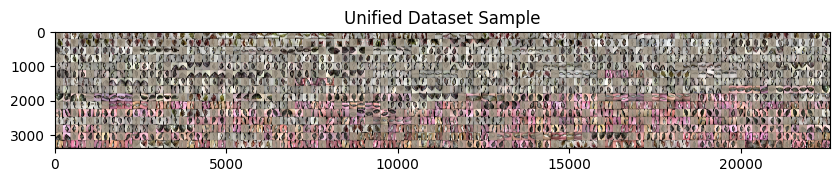

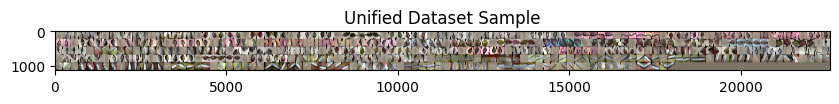

In [ ]:
import os
import random
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from PIL import Image

# Load augmentation parameters
TRAINING_PARAMS_YAML = os.path.join(CONFIG_PATH, 'training_params.yaml')
augment_params = load_yaml_config(TRAINING_PARAMS_YAML)

augmentation_config = augment_params['augmentations']
resize_scale = augmentation_config['resize_scale']
horizontal_flip_prob = augmentation_config['horizontal_flip']
vertical_flip_prob = augmentation_config['vertical_flip']
rotation_degrees = augmentation_config['rotation_degrees']
brightness = augmentation_config['brightness']
contrast = augmentation_config['contrast']
saturation = augmentation_config['saturation']
hue = augmentation_config['hue']
gaussian_blur_kernel = augmentation_config['gaussian_blur_kernel']
gamma_range = augmentation_config['gamma_range']
erasing_scale = augmentation_config['erasing_scale']
erase_ratio = augmentation_config['erase_ratio']

# Data transformation/augmentation pipeline setup
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(resize_scale[0], resize_scale[1])),
    transforms.RandomHorizontalFlip(p=horizontal_flip_prob),
    transforms.RandomVerticalFlip(p=vertical_flip_prob),
    transforms.RandomRotation(degrees=rotation_degrees),
    transforms.ColorJitter(brightness=brightness, contrast=contrast,
                           saturation=saturation, hue=hue),
    transforms.GaussianBlur(kernel_size=random.choice(gaussian_blur_kernel)),
    transforms.RandomApply([transforms.RandomAdjustSharpness(random.uniform(gamma_range[0], gamma_range[1]), p=0.5)], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomErasing(scale=(erasing_scale[0], erasing_scale[1]),
                             ratio=(erase_ratio[0], erase_ratio[1]), p=0.5)
])

def store_augmented_images(image_paths, transform, n_images=16, augmentations_per_image=5):
    stored_images = []  # List to hold all images

    for img_path in image_paths[:n_images]:
        # Store the original image without transformation
        img = Image.open(img_path).convert('RGB')
        img_tensor = transforms.ToTensor()(img)  # Convert original image to tensor
        stored_images.append(img_tensor)  # Append original image (as tensor)

        # Generate and store augmented images
        for _ in range(augmentations_per_image):
            augmented_image = transform(img)  # Transform the original image
            stored_images.append(augmented_image)  # Append augmented image

    return stored_images

# Function to print a comparison of original and augmented image counts
def print_image_comparison(original_count, augmented_count, dataset_type):
    added_count = augmented_count - original_count
    print(f"{dataset_type}:")
    print(f"Original Image Count: {original_count}")
    print(f"Combined Original & Augmented Count: {augmented_count}")
    print(f"Total Added via Augmentation: {added_count}\n")

def show_unified_dataset(images, n_images=4000):
    """Display a grid of images from the unified dataset."""

    images_to_show = images[:n_images]  # Select the first n_images for display
    grid = make_grid(images_to_show, nrow=100, padding=2)  # 150 images per row

    # Unnormalize the images for display
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    grid = grid * std + mean  # Denormalize

    # Convert tensor to numpy for plotting
    grid = grid.permute(1, 2, 0).numpy()

    # Plot the grid
    plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
    plt.imshow(grid)
    plt.axis('on')  # Hide the axes
    plt.title("Unified Dataset Sample")
    plt.show()

# Example usage:
train_data = [os.path.join(CLEANED_TRAIN_IMAGES_PATH, f) for f in os.listdir(CLEANED_TRAIN_IMAGES_PATH)]
valid_data = [os.path.join(CLEANED_VALID_IMAGES_PATH, f) for f in os.listdir(CLEANED_VALID_IMAGES_PATH)]

# Store all images in unified datasets
unified_train_dataset = store_augmented_images(train_data, data_transforms, n_images=250, augmentations_per_image=5)
unified_valid_dataset = store_augmented_images(valid_data, data_transforms, n_images=80, augmentations_per_image=5)

# Count images
total_unaugmented_train_imgs = len(train_data)
total_unaugmented_valid_imgs = len(valid_data)

# Since each original image has 5 augmentations plus the original itself, we need to add 5 per image
total_augmented_train_imgs = total_unaugmented_train_imgs * (1 + 5)  # 5 augmentations + 1 original
total_augmented_valid_imgs = total_unaugmented_valid_imgs * (1 + 5)  # 5 augmentations + 1 original

# Print comparison results
print_image_comparison(total_unaugmented_train_imgs, total_augmented_train_imgs, "Train")
print_image_comparison(total_unaugmented_valid_imgs, total_augmented_valid_imgs, "Valid")

# Calculate combined datasets
combined_train_dataset = total_augmented_train_imgs
combined_val_dataset = total_augmented_valid_imgs

# Print combined dataset results
print("Unified Train & Valid Datasets:")
show_unified_dataset(unified_train_dataset)
show_unified_dataset(unified_valid_dataset)

## Training Phase

### Model Training

In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision import models
from tqdm import tqdm
import yaml

TRAINING_PARAMS_YAML = os.path.join(CONFIG_PATH, 'training_params.yaml')
training_params = load_yaml_config(TRAINING_PARAMS_YAML)

num_epochs = training_params['training']['num_epochs']
batch_size = training_params['training']['batch_size']
learning_rate = training_params['training']['learning_rate']

# Load the datasets
train_dataset = datasets.ImageFolder(root=unified_train_dataset)
valid_dataset = datasets.ImageFolder(root=unified_valid_dataset)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pre-trained ResNet-18 model
resnet18 = models.resnet18(pretrained=True)

# Modify the final layer for the number of classes
num_classes = len(train_dataset.classes)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# Move the model to the device
resnet18 = resnet18.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    resnet18.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet18(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total * 100

    print(f"Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    # Validation phase
    resnet18.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = resnet18(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(valid_loader)
    val_accuracy = correct_val / total_val * 100

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

print("Training complete.")
print(resnet18)

## Load Trained Model's Architecture

In [ ]:
state_dict = torch.load('./runs/detect/HOOKitModel-pre-v0.3/weights/best.pt')

for key, value in state_dict.items():
    if isinstance(value, torch.Tensor):
        print(f"{key}: Tensor with shape {value.shape}")
    else:
        print(f"{key}: {type(value)} with value {value}")

## Testing Phase

_this section tests the TRAINED MODEL against UNSEEN DATA both static and realtime_

### Insert an Image Approach Inference OR Folder of Images

In [ ]:
import tkinter as tk
from tkinter import filedialog, messagebox, ttk
from ultralytics import YOLO
from PIL import Image, ImageTk
import numpy as np
import cv2
import os
import math
import sys


def create_image_grid(image_folder, grid_size=(5, 5)):
    """Create a grid of images from the output folder."""
    images = [img for img in os.listdir(
        image_folder) if img.startswith("output_")]
    if not images:
        print("No output images found.")
        return None

    n = min(len(images), grid_size[0] * grid_size[1])
    rows = min(grid_size[0], math.ceil(math.sqrt(n)))
    cols = min(grid_size[1], math.ceil(n / rows))

    with Image.open(os.path.join(image_folder, images[0])) as img:
        w, h = img.size

    grid_img = Image.new('RGB', (cols * w, rows * h), color='white')

    for i, image in enumerate(images[:n]):
        with Image.open(os.path.join(image_folder, image)) as img:
            grid_img.paste(img, ((i % cols) * w, (i // cols) * h))

    return grid_img


def load_model(model_path):
    """Load the YOLOv8 model."""
    try:
        return YOLO(model_path)
    except Exception as e:
        print(f"Error loading model: {e}")
        sys.exit(1)


def perform_inference(model, image_path):
    """Perform inference on the given image."""
    try:
        results = model(image_path)
        return results[0]
    except Exception as e:
        print(f"Error during inference: {e}")
        return None


def visualize_results(image_path, results):
    """Visualize the results on the image."""
    try:
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        result_plot = results.plot()
        return Image.fromarray(result_plot)
    except Exception as e:
        print(f"Error visualizing results: {e}")
        return None


def process_detections(results):
    """Process and return detection data."""
    detections = []
    for box in results.boxes:
        detections.append({
            'box': box.xyxy[0].tolist(),
            'confidence': float(box.conf[0]),
            'class': int(box.cls[0])
        })
    return detections


def safe_save(image, output_path):
    """Save the image with a unique filename to avoid overwriting."""
    base, ext = os.path.splitext(output_path)
    counter = 1
    while os.path.exists(output_path):
        output_path = f"{base}_{counter}{ext}"
        counter += 1
    image.save(output_path)
    return output_path


def process_image(model, image_path, output_folder):
    """Process a single image."""
    results = perform_inference(model, image_path)
    if results is None:
        return

    result_image = visualize_results(image_path, results)
    if result_image is None:
        return

    filename = os.path.basename(image_path)
    output_path = os.path.join(output_folder, f"output_{filename}")
    saved_path = safe_save(result_image, output_path)
    print(f"Result image saved as '{saved_path}'")

    detections = process_detections(results)
    print(f"Detections for {filename}:")
    for detection in detections:
        print(f"Box: {detection['box']}")
        print(f"Confidence: {detection['confidence']}")
        print(f"Class: {detection['class']}")
        print("---")
    print("\n")


def process_folder(model, folder_path, output_folder):
    """Process all images in the specified folder."""
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
            image_path = os.path.join(folder_path, filename)
            process_image(model, image_path, output_folder)


def get_next_grid_number():
    i = 1
    while os.path.exists(f"image_grid_output_{i}.jpg"):
        i += 1
    return i


class YOLOApp:
    def __init__(self, master):
        self.master = master
        master.title("HOOKit pre-release v0.3")
        master.geometry("500x700")

        self.model = None
        self.current_image = None
        self.output_folder = None

        # Create main frame
        main_frame = ttk.Frame(master, padding="10")
        main_frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))
        master.columnconfigure(0, weight=1)
        master.rowconfigure(0, weight=1)

        # Model container
        model_frame = ttk.LabelFrame(
            main_frame, text="Model Selection", padding="10")
        model_frame.grid(row=0, column=0, columnspan=2,
                         sticky=(tk.W, tk.E), pady=5)
        model_frame.columnconfigure(1, weight=1)

        self.model_button = ttk.Button(
            model_frame, text="Load Model", command=self.load_model)
        self.model_button.grid(row=0, column=0, sticky=tk.W)

        self.current_model_label = ttk.Label(
            model_frame, text="Current Model: None")
        self.current_model_label.grid(
            row=0, column=1, sticky=tk.W, padx=(10, 0))

        # Image selection container
        image_frame = ttk.LabelFrame(
            main_frame, text="Image Selection", padding="10")
        image_frame.grid(row=1, column=0, sticky=(tk.W, tk.E), pady=5)
        image_frame.columnconfigure(1, weight=1)

        self.image_button = ttk.Button(
            image_frame, text="Choose Image", command=self.load_image)
        self.image_button.grid(row=0, column=0, sticky=tk.W)

        self.current_image_label = ttk.Label(
            image_frame, text="No image selected")
        self.current_image_label.grid(
            row=0, column=1, sticky=tk.W, padx=(10, 0))

        # Output folder container
        output_frame = ttk.LabelFrame(
            main_frame, text="Output Folder", padding="10")
        output_frame.grid(row=1, column=1, sticky=(tk.W, tk.E), pady=5)
        output_frame.columnconfigure(1, weight=1)

        self.output_button = ttk.Button(
            output_frame, text="Set Output Folder", command=self.set_output_folder)
        self.output_button.grid(row=0, column=0, sticky=tk.W)

        self.output_label = ttk.Label(output_frame, text="No folder selected")
        self.output_label.grid(row=0, column=1, sticky=tk.W, padx=(10, 0))

        # Infer container
        infer_frame = ttk.LabelFrame(
            main_frame, text="Inference", padding="10")
        infer_frame.grid(row=2, column=0, columnspan=2,
                         sticky=(tk.W, tk.E), pady=5)

        self.infer_button = ttk.Button(
            infer_frame, text="Infer Now", command=self.infer_now, state=tk.DISABLED)
        self.infer_button.pack()

        # Folder processing container
        folder_frame = ttk.LabelFrame(
            main_frame, text="Multiple Image Processing", padding="10")
        folder_frame.grid(row=3, column=0, columnspan=2,
                          sticky=(tk.W, tk.E), pady=5)

        self.folder_button = ttk.Button(
            folder_frame, text="Select a Folder", command=self.process_folder)
        self.folder_button.pack()

        # Real-time inference container
        realtime_frame = ttk.LabelFrame(
            main_frame, text="Real-time Inference", padding="10")
        realtime_frame.grid(row=4, column=0, columnspan=2,
                            sticky=(tk.W, tk.E), pady=5)

        self.realtime_button = ttk.Button(
            realtime_frame, text="Start Real-time Inference", command=self.toggle_realtime_inference)
        self.realtime_button.pack()

        self.camera_var = tk.StringVar()
        self.camera_dropdown = ttk.Combobox(
            realtime_frame, textvariable=self.camera_var)
        self.camera_dropdown.pack(pady=5)
        self.update_camera_list()

        # Add a label to display the webcam feed
        self.video_label = ttk.Label(main_frame)
        self.video_label.grid(row=5, column=0, columnspan=2, pady=5)

        # Initialize webcam variables
        self.cap = None
        self.is_realtime_active = False

    def load_model(self):
        model_path = filedialog.askopenfilename(
            filetypes=[("YOLO Model", "*.pt")])
        if model_path:
            try:
                self.model = load_model(model_path)
                model_name = os.path.basename(model_path)
                self.current_model_label.config(
                    text=f"Current Model: {model_name}")
                messagebox.showinfo("Success", "Model loaded successfully!")
            except Exception as e:
                messagebox.showerror(
                    "Error", f"Failed to load model: {str(e)}")

    def load_image(self):
        image_path = filedialog.askopenfilename(
            filetypes=[("Image files", "*.png *.jpg *.jpeg *.tiff *.bmp *.gif")])
        if image_path:
            self.current_image = image_path
            self.current_image_label.config(text=os.path.basename(image_path))
            self.infer_button.config(state=tk.NORMAL)
            messagebox.showinfo("Success", "Image loaded successfully!")

    def set_output_folder(self):
        self.output_folder = filedialog.askdirectory()
        if self.output_folder:
            self.output_label.config(text=os.path.basename(self.output_folder))
            messagebox.showinfo("Success", "Output folder set successfully!")

    def infer_now(self):
        if not self.model:
            messagebox.showerror("Error", "Please load a model first.")
            return
        if not self.output_folder:
            messagebox.showerror(
                "Error", "Please select an output folder first.")
            return
        if not self.current_image:
            messagebox.showerror("Error", "Please load an image first.")
            return

        process_image(self.model, self.current_image, self.output_folder)
        messagebox.showinfo("Success", "Image processed successfully!")

    def process_folder(self):
        if not self.model:
            messagebox.showerror("Error", "Please load a model first.")
            return
        if not self.output_folder:
            messagebox.showerror(
                "Error", "Please select an output folder first.")
            return

        folder_path = filedialog.askdirectory()
        if folder_path:
            process_folder(self.model, folder_path, self.output_folder)
            grid_image = create_image_grid(
                self.output_folder, grid_size=(5, 5))
            if grid_image:
                grid_number = get_next_grid_number()
                grid_filename = f"image_grid_output_{grid_number}.jpg"
                grid_image.save(os.path.join(
                    self.output_folder, grid_filename))
                messagebox.showinfo(
                    "Success", f"Folder processed and grid image saved as '{grid_filename}'")
            else:
                messagebox.showinfo(
                    "Success", "Folder processed successfully!")

    def list_available_cameras(self):
        index = 0
        cameras = []
        while True:
            cap = cv2.VideoCapture(index)
            if not cap.read()[0]:
                break
            else:
                cameras.append(index)
            cap.release()
            index += 1
        return cameras

    def update_camera_list(self):
        cameras = self.list_available_cameras()
        self.camera_dropdown['values'] = [f"Camera {i}" for i in cameras]
        if cameras:
            self.camera_dropdown.set(f"Camera {cameras[0]}")

    def toggle_realtime_inference(self):
        if not self.model:
            messagebox.showerror("Error", "Please load a model first.")
            return

        if self.is_realtime_active:
            self.stop_realtime_inference()
        else:
            self.start_realtime_inference()

    def start_realtime_inference(self):
        camera_index = int(self.camera_var.get().split()[-1])
        self.cap = cv2.VideoCapture(camera_index)
        if not self.cap.isOpened():
            messagebox.showerror(
                "Error", f"Failed to open camera {camera_index}")
            return
        self.is_realtime_active = True
        self.realtime_button.config(text="Stop Real-time Inference")
        self.update_webcam()

    def stop_realtime_inference(self):
        if self.cap:
            self.cap.release()
        self.is_realtime_active = False
        self.realtime_button.config(text="Start Real-time Inference")
        self.video_label.config(image='')

    def update_webcam(self):
        if self.is_realtime_active:
            ret, frame = self.cap.read()
            if ret:
                results = self.model(frame)
                result_frame = results[0].plot()
                img = Image.fromarray(cv2.cvtColor(
                    result_frame, cv2.COLOR_BGR2RGB))
                img = ImageTk.PhotoImage(img)
                self.video_label.config(image=img)
                self.video_label.image = img
            self.master.after(10, self.update_webcam)

    def on_closing(self):
        if self.cap:
            self.cap.release()
        self.master.destroy()


def main():
    root = tk.Tk()
    app = YOLOApp(root)
    root.protocol("WM_DELETE_WINDOW", app.on_closing)
    root.mainloop()


if __name__ == "__main__":
    main()

In [ ]:
from PIL import Image, ImageTk

### Inference via Realtime Camera

In [ ]:
%pip install ultralytics opencv-python

from ultralytics import YOLO
import cv2

# Load the newly custom trained model
model = YOLO(MODEL_PATH)

# Open the laptop camera
cap = cv2.VideoCapture(1)

while True:
    # Read a frame from the camera
    ret, frame = cap.read()

    if not ret:
        break

    # Run inference on the frame
    results = model(frame)

    # Visualize the results on the frame
    annotated_frame = results[0].plot()

    # Display the annotated frame
    cv2.imshow("HOOKitModel-pre-v0.3", annotated_frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the camera and close windows
cap.release()
cv2.destroyAllWindows()

## Pre-Deployment Phase

### Export the Base Model Summary into a .DOCX File

In [ ]:
# Parse the data
data = []
for line in """from n params module arguments
0 -1 1 464 ultralytics.nn.modules.conv.Conv [3, 16, 3, 2]
1 -1 1 4672 ultralytics.nn.modules.conv.Conv [16, 32, 3, 2]
2 -1 1 7360 ultralytics.nn.modules.block.C2f [32, 32, 1, True]
3 -1 1 18560 ultralytics.nn.modules.conv.Conv [32, 64, 3, 2]
4 -1 2 49664 ultralytics.nn.modules.block.C2f [64, 64, 2, True]
5 -1 1 73984 ultralytics.nn.modules.conv.Conv [64, 128, 3, 2]
6 -1 2 197632 ultralytics.nn.modules.block.C2f [128, 128, 2, True]
7 -1 1 295424 ultralytics.nn.modules.conv.Conv [128, 256, 3, 2]
8 -1 1 460288 ultralytics.nn.modules.block.C2f [256, 256, 1, True]
9 -1 1 164608 ultralytics.nn.modules.block.SPPF [256, 256, 5]
10 -1 1 0 torch.nn.modules.upsampling.Upsample [None, 2, 'nearest']
11 [-1, 6] 1 0 ultralytics.nn.modules.conv.Concat [1]
12 -1 1 148224 ultralytics.nn.modules.block.C2f [384, 128, 1]
13 -1 1 0 torch.nn.modules.upsampling.Upsample [None, 2, 'nearest']
14 [-1, 4] 1 0 ultralytics.nn.modules.conv.Concat [1]
15 -1 1 37248 ultralytics.nn.modules.block.C2f [192, 64, 1]
16 -1 1 36992 ultralytics.nn.modules.conv.Conv [64, 64, 3, 2]
17 [-1, 12] 1 0 ultralytics.nn.modules.conv.Concat [1]
18 -1 1 123648 ultralytics.nn.modules.block.C2f [192, 128, 1]
19 -1 1 147712 ultralytics.nn.modules.conv.Conv [128, 128, 3, 2]""".split('\n')[1:]:  # Skip the header
    parts = line.split()
    data.append({
        'n': parts[0],
        'from': parts[1],
        'params': parts[3],
        'module': parts[4],
        'arguments': ' '.join(parts[5:])
    })

# Create a pandas DataFrame
df = pd.DataFrame(data)

# Create a new Word document
doc = Document()

# Add a title
doc.add_heading('Model Summary', 0)

# Add the table
table = doc.add_table(rows=1, cols=5)
table.style = 'Table Grid'

# Add the header row
header_cells = table.rows[0].cells
header_cells[0].text = 'n'
header_cells[1].text = 'from'
header_cells[2].text = 'params'
header_cells[3].text = 'module'
header_cells[4].text = 'arguments'

# Add the data rows
for _, row in df.iterrows():
    cells = table.add_row().cells
    cells[0].text = row['n']
    cells[1].text = row['from']
    cells[2].text = row['params']
    cells[3].text = row['module']
    cells[4].text = row['arguments']

# Add the summary
doc.add_paragraph(
    '\nModel summary: 225 layers, 3014748 parameters, 3014732 gradients, 8.2 GFLOPs')

# Save the document
doc.save('model_summary.docx')

print("Document 'model_summary.docx' has been created.")

### Convert and Export Trained Model to ONNX

In [ ]:
import tensorflow.keras as tf_keras

# Select what format to be EXPORTED
print("Select the format you want to export to: \n\t 1. ONNX \n\t 2. TFLite \n\t 3. CoreML")

try:
    model_format = int(input())

    if model_format == 1:
        model_format = "onnx"
    elif model_format == 2:
        model_format = "tflite"
    elif model_format == 3:
        model_format = "coreml"
    else:
        raise ValueError
except ValueError:
    raise ValueError("Wrong format selected, please select 1 or 2 or 3 only.")

# Load your model

model = YOLO(MODEL_PATH)
print(f"Model was successfully loaded from {MODEL_PATH}!")
print(f"We're now EXPORTING your model to {model_format.upper()} format!")


# Export the model to whatever chosen
model.export(format=model_format)

print(f"Model was successfully exported to {format}!")

### Validate the ONNX Model's Formation

In [ ]:
# Load the ONNX model
onnx_model = onnx.load(ONNX_PATH)

# Check that the model if it is well formed
onnx.checker.check_model(onnx_model)

print("Model was successfully converted to ONNX and is well-formed!")

## Utilities

### AquaGrade's Smart Nitpicker of Dataspecimen

In [ ]:
import os
import shutil
import random
from tkinter import Tk, filedialog, messagebox, Label
from PIL import Image, ImageTk

COPIED_IMAGES_FILE = "copied_images.txt"


def select_folder(root):
    while True:
        folder_path = filedialog.askdirectory(
            title="Select folder containing images")
        if folder_path:
            return folder_path
        else:
            if messagebox.askokcancel("Exit", "No folder selected. Do you want to exit?"):
                root.quit()
                return None


def create_new_folder(parent_path):
    while True:
        new_folder_name = input(
            "Enter a name for the destination folder (default: Copied_Images): ").strip()
        if not new_folder_name:
            new_folder_name = "Copied_Images"
        new_folder_path = os.path.join(parent_path, new_folder_name)
        try:
            os.makedirs(new_folder_path, exist_ok=True)
            return new_folder_path
        except PermissionError:
            print("Permission denied. Please choose a different name.")
        except OSError as e:
            print(f"Error creating folder: {e}")


def get_file_types():
    print("Select file types to copy (separate with commas):")
    print("1. PNG")
    print("2. JPG/JPEG")
    print("3. GIF")
    print("4. BMP")
    print("5. All of the above")
    choice = input("Enter your choices (e.g., 1,2,3): ")
    types = {
        '1': '.png', '2': ('.jpg', '.jpeg'), '3': '.gif', '4': '.bmp',
        '5': ('.png', '.jpg', '.jpeg', '.gif', '.bmp')
    }
    selected = set()
    for c in choice.split(','):
        selected.update(types.get(c.strip(), ()))
    return selected


def load_copied_images():
    if os.path.exists(COPIED_IMAGES_FILE):
        with open(COPIED_IMAGES_FILE, "r") as f:
            return set(line.strip() for line in f)
    return set()


def save_copied_image(image_name):
    with open(COPIED_IMAGES_FILE, "a") as f:
        f.write(f"{image_name}\n")


def copy_random_images(source_folder, destination_folder, num_images, file_types):
    copied_images_set = load_copied_images()
    image_files = [f for f in os.listdir(source_folder)
                   if os.path.splitext(f.lower())[1] in file_types and f not in copied_images_set]

    if not image_files:
        print("No matching image files found in the selected folder.")
        return []

    num_to_copy = min(num_images, len(image_files))
    selected_images = random.sample(image_files, num_to_copy)

    copied_images = []
    for image in selected_images:
        source_path = os.path.join(source_folder, image)
        destination_path = os.path.join(destination_folder, image)
        try:
            shutil.copy2(source_path, destination_path)
            copied_images.append(destination_path)
            save_copied_image(image)
            print(f"Copied '{image}' to '{destination_folder}'")
        except (PermissionError, OSError) as e:
            print(f"Error copying '{image}': {e}")

    print(f"Copied {len(copied_images)} out of {
          num_to_copy} requested images to '{destination_folder}'")
    return copied_images


def get_number_of_images():
    while True:
        try:
            num = int(input("How many images would you like to copy? "))
            if num > 0:
                return num
            else:
                print("Please enter a positive number.")
        except ValueError:
            print("Please enter a valid number.")


def preview_images(root, image_paths):
    root.deiconify()  # Make sure the window is visible
    root.title("Image Preview")

    for i, path in enumerate(image_paths):
        try:
            img = Image.open(path)
            img.thumbnail((100, 100))
            photo = ImageTk.PhotoImage(img)
            label = Label(root, image=photo)
            label.image = photo
            label.grid(row=i//5, column=i % 5, padx=5, pady=5)
        except Exception as e:
            print(f"Error previewing image {path}: {e}")


def on_closing():
    if os.path.exists(COPIED_IMAGES_FILE):
        os.remove(COPIED_IMAGES_FILE)
    root.destroy()


def main():
    global root
    root = Tk()

    while True:
        source_folder = select_folder(root)
        if not source_folder:
            print("Exiting the program.")
            return

        num_images = get_number_of_images()
        file_types = get_file_types()

        parent_folder = os.path.dirname(source_folder)
        new_folder = create_new_folder(parent_folder)

        copied_images = copy_random_images(
            source_folder, new_folder, num_images, file_types)

        if copied_images:
            preview_images(root, copied_images)

        if messagebox.askyesno("Repeat", "Do you want to select another folder and copy more images?"):
            continue
        else:
            break

    root.protocol("WM_DELETE_WINDOW", on_closing)
    root.mainloop()


if __name__ == "__main__":
    main()

### AquaGrade's Folder Image Division

In [ ]:
import os
import shutil
import math
import tkinter as tk
from tkinter import filedialog, messagebox


def divide_images():
    source_folder = source_entry.get()
    destination_folder = dest_entry.get()

    try:
        num_divisions = int(divisions_entry.get())
    except ValueError:
        messagebox.showerror(
            "Error", "Number of divisions must be an integer.")
        return

    if not source_folder or not destination_folder or num_divisions <= 0:
        messagebox.showerror("Error", "Please fill in all fields correctly.")
        return

    if not os.path.exists(source_folder):
        messagebox.showerror("Error", "Source folder does not exist.")
        return

    # Create the destination folder if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Get all image files from the source folder
    image_files = [f for f in os.listdir(source_folder) if f.lower().endswith(
        ('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

    # Remove duplicates (if any) based on filenames
    image_files = list(dict.fromkeys(image_files))

    if not image_files:
        messagebox.showerror(
            "Error", "No image files found in the source folder.")
        return

    # Calculate the number of images per division
    images_per_division = math.ceil(len(image_files) / num_divisions)

    # Keep track of copied images
    copied_images = set()

    # Divide and copy the images
    for i in range(num_divisions):
        # Create a new subfolder for each division
        subfolder_name = f"batch_{i+1}"
        subfolder_path = os.path.join(destination_folder, subfolder_name)
        os.makedirs(subfolder_path, exist_ok=True)

        # Calculate the range of images for this division
        start_index = i * images_per_division
        end_index = min((i + 1) * images_per_division, len(image_files))

        # Copy the images to the subfolder
        for image_file in image_files[start_index:end_index]:
            if image_file not in copied_images:
                source_path = os.path.join(source_folder, image_file)
                destination_path = os.path.join(subfolder_path, image_file)
                shutil.copy2(source_path, destination_path)
                copied_images.add(image_file)

    messagebox.showinfo("Success", f"Images divided into {num_divisions} folders successfully.\n"
                        f"{len(copied_images)} unique images copied.\n"
                        f"Original folder '{source_folder}' remains unchanged.")


def browse_source():
    folder_selected = filedialog.askdirectory()
    source_entry.delete(0, tk.END)
    source_entry.insert(0, folder_selected)


def browse_dest():
    folder_selected = filedialog.askdirectory()
    dest_entry.delete(0, tk.END)
    dest_entry.insert(0, folder_selected)


# Create the main window
root = tk.Tk()
root.title("Image Folder Divider")
root.geometry("400x200")

# Source folder
tk.Label(root, text="Source Folder:").grid(
    row=0, column=0, sticky="e", padx=5, pady=5)
source_entry = tk.Entry(root, width=30)
source_entry.grid(row=0, column=1, padx=5, pady=5)
tk.Button(root, text="Browse", command=browse_source).grid(
    row=0, column=2, padx=5, pady=5)

# Destination folder
tk.Label(root, text="Destination Folder:").grid(
    row=1, column=0, sticky="e", padx=5, pady=5)
dest_entry = tk.Entry(root, width=30)
dest_entry.grid(row=1, column=1, padx=5, pady=5)
tk.Button(root, text="Browse", command=browse_dest).grid(
    row=1, column=2, padx=5, pady=5)

# Number of divisions
tk.Label(root, text="Number of Divisions:").grid(
    row=2, column=0, sticky="e", padx=5, pady=5)
divisions_entry = tk.Entry(root, width=30)
divisions_entry.grid(row=2, column=1, padx=5, pady=5)

# Divide button
tk.Button(root, text="Divide Images", command=divide_images).grid(
    row=3, column=1, pady=20)

root.mainloop()